**In this notebook, we demonstrate the application of basic Machine Learning Models and some basic Model Evaluation Metrics to perform classification task with Chicago Crime Dataset**

In general, An Ensemble Voting Model consist of Random Forest, Neural Network and KNN are used for the classification task of predicting the Type of Crime. Feel free to drop a comment and feedback.

In [73]:
# Visualization Libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#Preprocessing Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

# ML Libraries
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Evaluation Metrics
from yellowbrick.classifier import ClassificationReport
from sklearn import metrics

In [75]:
df = pd.concat([pd.read_csv('../input/Chicago_Crimes_2001_to_2004.csv', error_bad_lines=False), pd.read_csv('../input/Chicago_Crimes_2005_to_2007.csv', error_bad_lines=False)], ignore_index=True)
df = pd.concat([df, pd.read_csv('../input/Chicago_Crimes_2008_to_2011.csv', error_bad_lines=False)], ignore_index=True)
df = pd.concat([df, pd.read_csv('../input/Chicago_Crimes_2012_to_2017.csv', error_bad_lines=False)], ignore_index=True)
df.head()

b'Skipping line 1513591: expected 23 fields, saw 24\n'
/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (17,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
b'Skipping line 533719: expected 23 fields, saw 24\n'
b'Skipping line 1149094: expected 23 fields, saw 41\n'


,Unnamed: 0,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,879,4786321,HM399414,01/01/2004 12:01:00 AM,082XX S COLES AVE,0840,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,False,False,424,4.0,7.0,46.0,06,NaN,NaN,2004.0,08/17/2015 03:03:40 PM,NaN,NaN,NaN
1,2544,4676906,HM278933,03/01/2003 12:00:00 AM,004XX W 42ND PL,2825,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,True,935,9.0,11.0,61.0,26,1173974.0,1.87676e+06,2003.0,04/15/2016 08:55:02 AM,41.8172,-87.637328,"(41.817229156, -87.637328162)"
2,2919,4789749,HM402220,06/20/2004 11:00:00 AM,025XX N KIMBALL AVE,1752,OFFENSE INVOLVING CHILDREN,AGG CRIM SEX ABUSE FAM MEMBER,RESIDENCE,False,False,1413,14.0,35.0,22.0,20,NaN,NaN,2004.0,08/17/2015 03:03:40 PM,NaN,NaN,NaN
3,2927,4789765,HM402058,12/30/2004 08:00:00 PM,045XX W MONTANA ST,0840,THEFT,FINANCIAL ID THEFT: OVER $300,OTHER,False,False,2521,25.0,31.0,20.0,06,NaN,NaN,2004.0,08/17/2015 03:03:40 PM,NaN,NaN,NaN
4,3302,4677901,HM275615,05/01/2003 01:00:00 AM,111XX S NORMAL AVE,0841,THEFT,FINANCIAL ID THEFT:$300 &UNDER,RESIDENCE,False,False,2233,22.0,34.0,49.0,06,1174948.0,1.83105e+06,2003.0,04/15/2016 08:55:02 AM,41.6918,-87.635116,"(41.691784636, -87.635115968)"


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7941282 entries, 0 to 7941281
Data columns (total 23 columns):
Unnamed: 0              int64
ID                      int64
Case Number             object
Date                    object
Block                   object
IUCR                    object
Primary Type            object
Description             object
Location Description    object
Arrest                  bool
Domestic                bool
Beat                    int64
District                float64
Ward                    float64
Community Area          float64
FBI Code                object
X Coordinate            float64
Y Coordinate            object
Year                    float64
Updated On              object
Latitude                object
Longitude               float64
Location                object
dtypes: bool(2), float64(6), int64(3), object(12)
memory usage: 1.3+ GB


In [77]:
# Preprocessing
# Remove NaN Value (As Dataset is huge, the NaN row could be neglectable)  
df = df.dropna()

In [78]:
# As the dataset is too huge is size, we would just subsampled a dataset for modelling as proof of concept
df = df.sample(n=10000)

In [79]:
# Remove irrelevant/not meaningfull attributes
df = df.drop(['Unnamed: 0'], axis=1)
df = df.drop(['ID'], axis=1)
df = df.drop(['Case Number'], axis=1) 

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 2117392 to 1688226
Data columns (total 20 columns):
Date                    10000 non-null object
Block                   10000 non-null object
IUCR                    10000 non-null object
Primary Type            10000 non-null object
Description             10000 non-null object
Location Description    10000 non-null object
Arrest                  10000 non-null bool
Domestic                10000 non-null bool
Beat                    10000 non-null int64
District                10000 non-null float64
Ward                    10000 non-null float64
Community Area          10000 non-null float64
FBI Code                10000 non-null object
X Coordinate            10000 non-null float64
Y Coordinate            10000 non-null object
Year                    10000 non-null float64
Updated On              10000 non-null object
Latitude                10000 non-null object
Longitude               10000 non-null float64
Location

In [80]:
# Splitting the Date to Day, Month, Year, Hour, Minute, Second
df['date2'] = pd.to_datetime(df['Date'])
df['Year'] = df['date2'].dt.year
df['Month'] = df['date2'].dt.month
df['Day'] = df['date2'].dt.day
df['Hour'] = df['date2'].dt.hour
df['Minute'] = df['date2'].dt.minute
df['Second'] = df['date2'].dt.second 
df = df.drop(['Date'], axis=1) 
df = df.drop(['date2'], axis=1) 
df = df.drop(['Updated On'], axis=1)
df.head()

,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Latitude,Longitude,Location,Month,Day,Hour,Minute,Second
2117392,014XX W 47TH ST,041A,BATTERY,AGGRAVATED: HANDGUN,SIDEWALK,False,False,921,9.0,3.0,61.0,04B,1167305.0,1.87358e+06,2006,41.8086,-87.661883,"(41.808645771, -87.661883006)",9,8,16,5,0
7625051,056XX W DIVERSEY AVE,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2514,25.0,31.0,19.0,14,1138335.0,1.91805e+06,2015,41.9313,-87.767064,"(41.931263196, -87.767064113)",10,13,8,0,0
4972323,106XX S WENTWORTH AVE,143A,WEAPONS VIOLATION,UNLAWFUL POSS OF HANDGUN,SIDEWALK,True,False,512,5.0,34.0,49.0,15,1176839.0,1.83417e+06,2008,41.7003,-87.628099,"(41.700309589, -87.628099219)",1,11,16,40,0
1391071,044XX S WASHTENAW AVE,041A,BATTERY,AGGRAVATED: HANDGUN,VEHICLE NON-COMMERCIAL,False,False,912,9.0,12.0,58.0,04B,1159108.0,1.87518e+06,2003,41.8132,-87.691904,"(41.813208177, -87.691904147)",11,21,22,20,0
3456375,073XX S PAULINA ST,1811,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,SIDEWALK,True,False,735,7.0,17.0,67.0,18,1166284.0,1.85601e+06,2005,41.7605,-87.666128,"(41.760475276, -87.666127647)",5,28,21,50,0


In [81]:
# Convert Categorical Attributes to Numerical
df['Block'] = pd.factorize(df["Block"])[0]
df['IUCR'] = pd.factorize(df["IUCR"])[0]
df['Description'] = pd.factorize(df["Description"])[0]
df['Location Description'] = pd.factorize(df["Location Description"])[0]
df['FBI Code'] = pd.factorize(df["FBI Code"])[0]
df['Location'] = pd.factorize(df["Location"])[0] 

In [83]:
Target = 'Primary Type'
print('Target: ', Target)

Target:  Primary Type


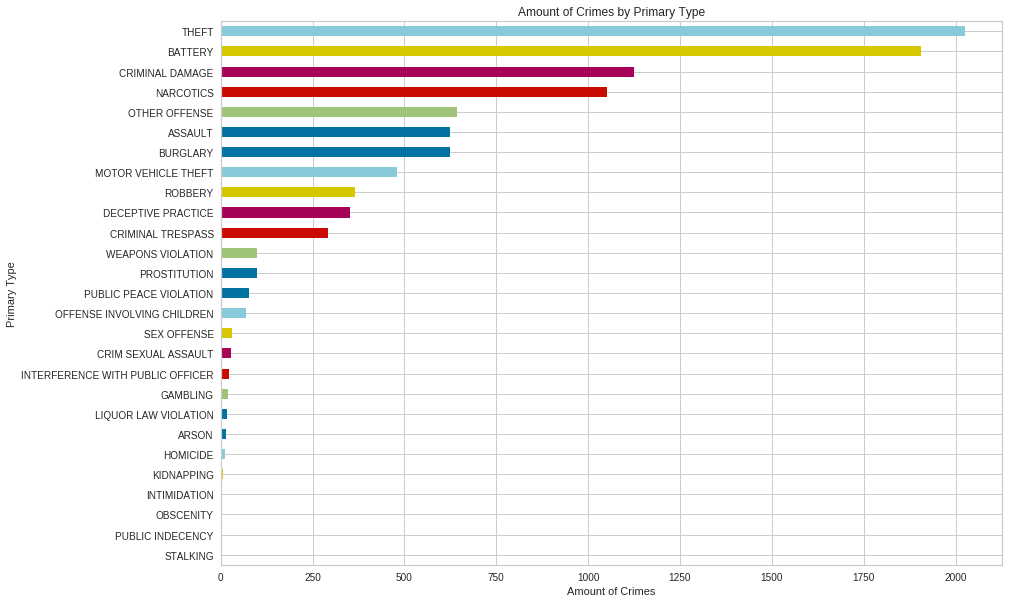

In [84]:
# Plot Bar Chart visualize Primary Types
plt.figure(figsize=(14,10))
plt.title('Amount of Crimes by Primary Type')
plt.ylabel('Crime Type')
plt.xlabel('Amount of Crimes')

df.groupby([df['Primary Type']]).size().sort_values(ascending=True).plot(kind='barh')

plt.show()

In [85]:
# At previous plot, we could see that the classes is quite imbalance
# Therefore, we are going to group several less occured Crime Type into 'Others' to reduce the Target Class amount

# First, we sum up the amount of Crime Type happened and select the last 13 classes
all_classes = df.groupby(['Primary Type'])['Block'].size().reset_index()
all_classes['Amt'] = all_classes['Block']
all_classes = all_classes.drop(['Block'], axis=1)
all_classes = all_classes.sort_values(['Amt'], ascending=[False])

unwanted_classes = all_classes.tail(13)
unwanted_classes

,Primary Type,Amt
17,OFFENSE INVOLVING CHILDREN,69
23,SEX OFFENSE,31
4,CRIM SEXUAL ASSAULT,29
10,INTERFERENCE WITH PUBLIC OFFICER,22
8,GAMBLING,20
13,LIQUOR LAW VIOLATION,16
0,ARSON,15
9,HOMICIDE,13
12,KIDNAPPING,7
11,INTIMIDATION,4


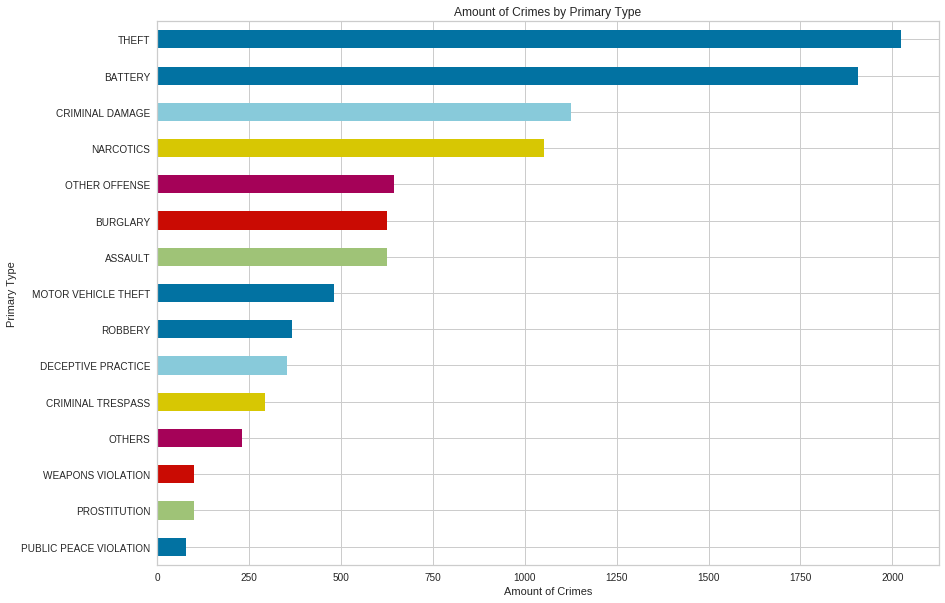

In [86]:
# After that, we replaced it with label 'OTHERS'
df.loc[df['Primary Type'].isin(unwanted_classes['Primary Type']), 'Primary Type'] = 'OTHERS'

# Plot Bar Chart visualize Primary Types
plt.figure(figsize=(14,10))
plt.title('Amount of Crimes by Primary Type')
plt.ylabel('Crime Type')
plt.xlabel('Amount of Crimes')

df.groupby([df['Primary Type']]).size().sort_values(ascending=True).plot(kind='barh')

plt.show()

In [87]:
# Now we are left with 14 Class as our predictive class
Classes = df['Primary Type'].unique()
Classes

array(['BATTERY', 'CRIMINAL DAMAGE', 'WEAPONS VIOLATION', 'NARCOTICS',
       'THEFT', 'OTHER OFFENSE', 'BURGLARY', 'OTHERS',
       'MOTOR VEHICLE THEFT', 'ASSAULT', 'ROBBERY', 'DECEPTIVE PRACTICE',
       'PUBLIC PEACE VIOLATION', 'CRIMINAL TRESPASS', 'PROSTITUTION'],
      dtype=object)

In [88]:
#Encode target labels into categorical variables:
df['Primary Type'] = pd.factorize(df["Primary Type"])[0] 
df['Primary Type'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

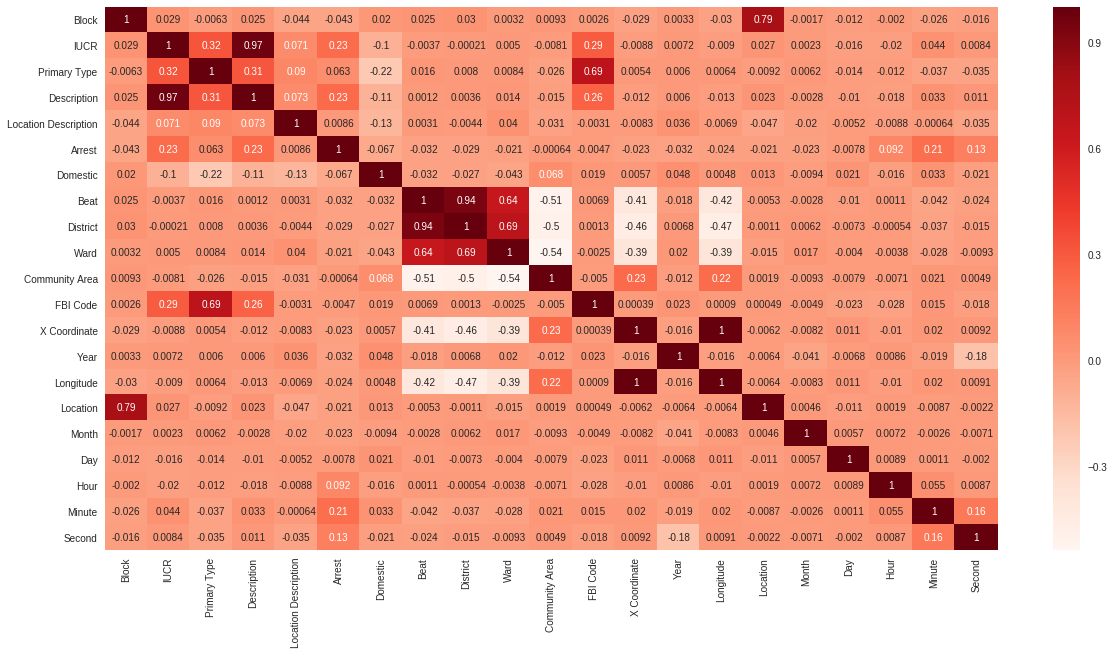

In [89]:
# Feature Selection using Filter Method 
# Split Dataframe to target class and features
X_fs = df.drop(['Primary Type'], axis=1)
Y_fs = df['Primary Type']

#Using Pearson Correlation
plt.figure(figsize=(20,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

**Further Elaboration of Correlation**

The correlation coefficient has values between -1 to 1
* A value closer to 0 implies weaker correlation (exact 0 implying no correlation)
* A value closer to 1 implies stronger positive correlation
* A value closer to -1 implies stronger negative correlation

In [92]:
#Correlation with output variable
cor_target = abs(cor['Primary Type'])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.3]
relevant_features

IUCR            0.318117
Primary Type    1.000000
Description     0.309946
FBI Code        0.689990
Name: Primary Type, dtype: float64

In [93]:
# At Current Point, the attributes is select manually based on Feature Selection Part. 
Features = ["IUCR", "Description", "FBI Code"]
print('Full Features: ', Features)

Full Features:  ['IUCR', 'Description', 'FBI Code']


In [94]:
#Split dataset to Training Set & Test Set
x, y = train_test_split(df, 
                        test_size = 0.2, 
                        train_size = 0.8, 
                        random_state= 3)

x1 = x[Features]    #Features to train
x2 = x[Target]      #Target Class to train
y1 = y[Features]    #Features to test
y2 = y[Target]      #Target Class to test

print('Feature Set Used    : ', Features)
print('Target Class        : ', Target)
print('Training Set Size   : ', x.shape)
print('Test Set Size       : ', y.shape)

Feature Set Used    :  ['IUCR', 'Description', 'FBI Code']
Target Class        :  Primary Type
Training Set Size   :  (8000, 23)
Test Set Size       :  (2000, 23)


**Machine Learning Modelling**

In [95]:
# Random Forest
# Create Model with configuration
rf_model = RandomForestClassifier(n_estimators=70, # Number of trees
                                  min_samples_split = 30,
                                  bootstrap = True, 
                                  max_depth = 50, 
                                  min_samples_leaf = 25)

# Model Training
rf_model.fit(X=x1,
             y=x2)

# Prediction
result = rf_model.predict(y[Features])

In [96]:
# Model Evaluation
ac_sc = accuracy_score(y2, result)
rc_sc = recall_score(y2, result, average="weighted")
pr_sc = precision_score(y2, result, average="weighted")
f1_sc = f1_score(y2, result, average='micro')
confusion_m = confusion_matrix(y2, result)

print("========== Random Forest Results ==========")
print("Accuracy    : ", ac_sc)
print("Recall      : ", rc_sc)
print("Precision   : ", pr_sc)
print("F1 Score    : ", f1_sc)
print("Confusion Matrix: ")
print(confusion_m)

========== Random Forest Results ==========
Accuracy    :  0.9735
Recall      :  0.9735
Precision   :  0.9733423140222878
F1 Score    :  0.9735
Confusion Matrix: 
[[380   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 205   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0  17   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 221   0   1   0   0   0   0   0   0   0   5   0]
 [  0   0   0   0 410   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 126   0   0   0   0   3   0   0   0   0]
 [  0   0   0   0   0   0 136   0   0   0   0   1   0   0   0]
 [  0   0   0   0   0   8   0  33   7   3   0   1   0   4   0]
 [  0   0   0   0   0   0   0   2  84   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   1   0 118   0   1   0   0   0]
 [  0   0   0   0   0   0   0   1   0   0  71   2   0   0   0]
 [  0   0   0   0   0   0   0   2   0   4   0  66   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0   9   1   0]
 [  0   0   0   0 

================= Classification Report =================

                        precision    recall  f1-score   support

               BATTERY       1.00      1.00      1.00       380
       CRIMINAL DAMAGE       1.00      1.00      1.00       205
     WEAPONS VIOLATION       1.00      0.94      0.97        18
             NARCOTICS       1.00      0.97      0.99       227
                 THEFT       1.00      1.00      1.00       410
         OTHER OFFENSE       0.92      0.98      0.95       129
              BURGLARY       1.00      0.99      1.00       137
                OTHERS       0.82      0.59      0.69        56
   MOTOR VEHICLE THEFT       0.92      0.98      0.95        86
               ASSAULT       0.93      0.98      0.96       120
               ROBBERY       0.96      0.96      0.96        74
    DECEPTIVE PRACTICE       0.93      0.92      0.92        72
PUBLIC PEACE VIOLATION       1.00      0.82      0.90        11
     CRIMINAL TRESPASS       0.85      0.95 

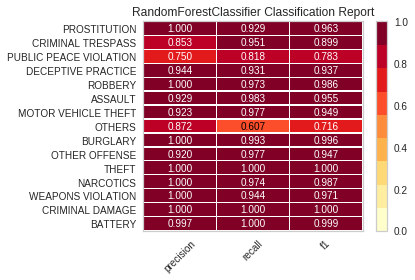

In [97]:
# Classification Report
# Instantiate the classification model and visualizer
target_names = Classes
visualizer = ClassificationReport(rf_model, classes=target_names)
visualizer.fit(X=x1, y=x2)     # Fit the training data to the visualizer
visualizer.score(y1, y2)       # Evaluate the model on the test data

print('================= Classification Report =================')
print('')
print(classification_report(y2, result, target_names=target_names))

g = visualizer.poof()             # Draw/show/poof the data

In [98]:
# Neural Network
# Create Model with configuration 
nn_model = MLPClassifier(solver='adam', 
                         alpha=1e-5,
                         hidden_layer_sizes=(40,), 
                         random_state=1,
                         max_iter=1000                         
                        )

# Model Training
nn_model.fit(X=x1,
             y=x2)

# Prediction
result = nn_model.predict(y[Features]) 

In [99]:
# Model Evaluation
ac_sc = accuracy_score(y2, result)
rc_sc = recall_score(y2, result, average="weighted")
pr_sc = precision_score(y2, result, average="weighted")
f1_sc = f1_score(y2, result, average='micro')
confusion_m = confusion_matrix(y2, result)

print("========== Neural Network Results ==========")
print("Accuracy    : ", ac_sc)
print("Recall      : ", rc_sc)
print("Precision   : ", pr_sc)
print("F1 Score    : ", f1_sc)
print("Confusion Matrix: ")
print(confusion_m)

========== Neural Network Results ==========
Accuracy    :  0.9585
Recall      :  0.9585
Precision   :  0.9608158707593915
F1 Score    :  0.9585
Confusion Matrix: 
[[380   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 205   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  17   1   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   2 219   0   6   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 410   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 117   3   0   0   0   0   0   0   9   0]
 [  0   0   0   0   0   1 136   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  10   0  27   0   0  11   0   1   5   2]
 [  0   0   0   0   0   0   0   0  86   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 117   1   2   0   0   0]
 [  0   0   0   0   0   0   0   1   0   0  65   8   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   3  68   0   0   1]
 [  0   0   0   0   1   1   0   0   0   0   0   0   9   0   0]
 [  0   0   0   0

================= Classification Report =================

                        precision    recall  f1-score   support

               BATTERY       1.00      1.00      1.00       380
       CRIMINAL DAMAGE       1.00      1.00      1.00       205
     WEAPONS VIOLATION       0.89      0.94      0.92        18
             NARCOTICS       1.00      0.96      0.98       227
                 THEFT       1.00      1.00      1.00       410
         OTHER OFFENSE       0.79      0.91      0.84       129
              BURGLARY       0.98      0.99      0.99       137
                OTHERS       0.93      0.48      0.64        56
   MOTOR VEHICLE THEFT       1.00      1.00      1.00        86
               ASSAULT       1.00      0.97      0.99       120
               ROBBERY       0.81      0.88      0.84        74
    DECEPTIVE PRACTICE       0.87      0.94      0.91        72
PUBLIC PEACE VIOLATION       0.90      0.82      0.86        11
     CRIMINAL TRESPASS       0.77      0.79 

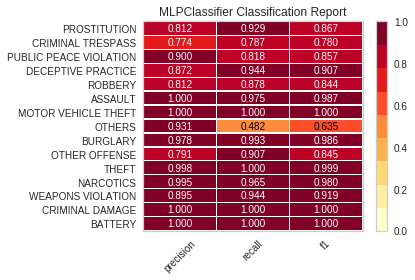

In [100]:
# Classification Report
# Instantiate the classification model and visualizer
target_names = Classes
visualizer = ClassificationReport(nn_model, classes=target_names)
visualizer.fit(X=x1, y=x2)     # Fit the training data to the visualizer
visualizer.score(y1, y2)       # Evaluate the model on the test data

print('================= Classification Report =================')
print('')
print(classification_report(y2, result, target_names=target_names))

g = visualizer.poof()             # Draw/show/poof the data

In [101]:
# Create Model with configuration 
knn_model = KNeighborsClassifier(n_neighbors=3)

# Model Training
knn_model.fit(X=x1,
             y=x2)

# Prediction
result = knn_model.predict(y[Features]) 

In [103]:
# Model Evaluation
ac_sc = accuracy_score(y2, result)
rc_sc = recall_score(y2, result, average="weighted")
pr_sc = precision_score(y2, result, average="weighted")
f1_sc = f1_score(y2, result, average='micro')
confusion_m = confusion_matrix(y2, result)

print("========== K-Nearest Neighbors Results ==========")
print("Accuracy    : ", ac_sc)
print("Recall      : ", rc_sc)
print("Precision   : ", pr_sc)
print("F1 Score    : ", f1_sc)
print("Confusion Matrix: ")
print(confusion_m)

========== K-Nearest Neighbors Results ==========
Accuracy    :  0.99
Recall      :  0.99
Precision   :  0.9902287279853924
F1 Score    :  0.99
Confusion Matrix: 
[[380   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 205   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  18   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   2 222   2   0   0   1   0   0   0   0   0   0   0]
 [  0   0   0   0 410   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 127   0   1   0   0   0   0   1   0   0]
 [  0   0   0   0   0   0 137   0   0   0   0   0   0   0   0]
 [  2   0   0   0   0   0   0  50   0   0   1   3   0   0   0]
 [  0   0   0   0   0   0   0   0  86   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   1   0 118   0   1   0   0   0]
 [  0   0   0   0   0   0   0   1   0   0  72   1   0   0   0]
 [  0   0   0   0   0   0   0   0   0   2   0  70   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  11   0   0]
 [  0   0   0   0 

================= Classification Report =================

                        precision    recall  f1-score   support

               BATTERY       0.99      1.00      1.00       380
       CRIMINAL DAMAGE       1.00      1.00      1.00       205
     WEAPONS VIOLATION       0.90      1.00      0.95        18
             NARCOTICS       1.00      0.98      0.99       227
                 THEFT       1.00      1.00      1.00       410
         OTHER OFFENSE       1.00      0.98      0.99       129
              BURGLARY       1.00      1.00      1.00       137
                OTHERS       0.93      0.89      0.91        56
   MOTOR VEHICLE THEFT       1.00      1.00      1.00        86
               ASSAULT       0.98      0.98      0.98       120
               ROBBERY       0.99      0.97      0.98        74
    DECEPTIVE PRACTICE       0.92      0.97      0.95        72
PUBLIC PEACE VIOLATION       0.92      1.00      0.96        11
     CRIMINAL TRESPASS       1.00      1.00 

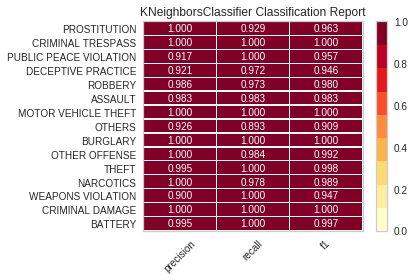

In [104]:
# Classification Report
# Instantiate the classification model and visualizer
target_names = Classes
visualizer = ClassificationReport(knn_model, classes=target_names)
visualizer.fit(X=x1, y=x2)     # Fit the training data to the visualizer
visualizer.score(y1, y2)       # Evaluate the model on the test data

print('================= Classification Report =================')
print('')
print(classification_report(y2, result, target_names=target_names))

g = visualizer.poof()             # Draw/show/poof the data

In [106]:
# Ensemble Voting Model
# Combine 3 Models to create an Ensemble Model

# Create Model with configuration
eclf1 = VotingClassifier(estimators=[('knn', knn_model), ('rf', rf_model), ('nn', nn_model)], 
                         weights=[1,1,1],
                         flatten_transform=True)
eclf1 = eclf1.fit(X=x1, y=x2)   

# Prediction
result = eclf1.predict(y[Features])

In [107]:
# Model Evaluation
ac_sc = accuracy_score(y2, result)
rc_sc = recall_score(y2, result, average="weighted")
pr_sc = precision_score(y2, result, average="weighted")
f1_sc = f1_score(y2, result, average='micro')
confusion_m = confusion_matrix(y2, result)

print("============= Ensemble Voting Results =============")
print("Accuracy    : ", ac_sc)
print("Recall      : ", rc_sc)
print("Precision   : ", pr_sc)
print("F1 Score    : ", f1_sc)
print("Confusion Matrix: ")
print(confusion_m)

============= Ensemble Voting Results =============
Accuracy    :  0.982
Recall      :  0.982
Precision   :  0.9820174429827548
F1 Score    :  0.982
Confusion Matrix: 
[[380   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 205   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  18   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   2 224   0   1   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 410   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 129   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1 136   0   0   0   0   0   0   0   0]
 [  2   0   0   0   0  10   0  36   0   0   8   0   0   0   0]
 [  0   0   0   0   0   0   0   0  86   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   1   0 118   0   1   0   0   0]
 [  0   0   0   0   0   0   0   2   0   0  70   2   0   0   0]
 [  0   0   0   0   0   0   0   2   0   0   0  70   0   0   0]
 [  0   0   0   0   1   1   0   0   0   0   0   0   9   0   0]
 [  0   0   0

================= Classification Report =================

                        precision    recall  f1-score   support

               BATTERY       0.99      1.00      1.00       380
       CRIMINAL DAMAGE       1.00      1.00      1.00       205
     WEAPONS VIOLATION       0.90      1.00      0.95        18
             NARCOTICS       1.00      0.99      0.99       227
                 THEFT       1.00      1.00      1.00       410
         OTHER OFFENSE       0.90      1.00      0.95       129
              BURGLARY       1.00      0.99      1.00       137
                OTHERS       0.86      0.64      0.73        56
   MOTOR VEHICLE THEFT       1.00      1.00      1.00        86
               ASSAULT       1.00      0.98      0.99       120
               ROBBERY       0.90      0.95      0.92        74
    DECEPTIVE PRACTICE       0.96      0.97      0.97        72
PUBLIC PEACE VIOLATION       1.00      0.82      0.90        11
     CRIMINAL TRESPASS       1.00      0.98 

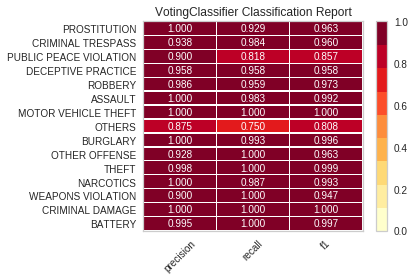

In [109]:
# Classification Report
# Instantiate the classification model and visualizer
target_names = Classes
visualizer = ClassificationReport(eclf1, classes=target_names)
visualizer.fit(X=x1, y=x2)     # Fit the training data to the visualizer
visualizer.score(y1, y2)       # Evaluate the model on the test data

print('================= Classification Report =================')
print('')
print(classification_report(y2, result, target_names=target_names))

g = visualizer.poof()             # Draw/show/poof the data